### gCDMI: Causal Discovery in Groups of Multivariate Timeseries

Notebook written by Wasim Ahmad <br> Computer Vision Group (CVG) <br> FSU Jena, Germany <br> Last updated on: May 02, 2024


The purpose of this notebook is to provide a simple usage example of the `gCDMI` for generating causal graph for mulativariate time series. Higher-dimensional time series may require additional computational time or the availaibility of a graphical processing unit.

In [153]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### Load Dependencies

In [154]:
import pickle
import time
import pathlib
import parameters
import numpy as np
import mxnet as mx
import pandas as pd
import preprocessing as prep
import matplotlib.pyplot as plt
from knockoffs import Knockoffs
from groupcause import groupCause
from gluonts.trainer import Trainer
from scms import StructuralCausalModel
from gluonts.dataset.common import ListDataset
from gluonts.model.deepar import DeepAREstimator
from gluonts.distribution.multivariate_gaussian import MultivariateGaussianOutput

In [155]:
np.random.seed(1)
mx.random.seed(2)

#### Load Model Parameters

The parameters for model archicture varies from application to application depends on data dimensionality mainly

In [156]:
start_time = time.time()
print(f'Time now: {start_time}')

# Parameters
pars = parameters.get_syn_params()
freq = pars.get('freq')
epochs = pars.get('epochs')
win_size = pars.get('win_size')
slidingwin_size = pars.get('slidingwin_size')
training_length = pars.get('train_len')
prediction_length = pars.get('pred_len')
num_samples = pars.get('num_samples')
num_layers = pars.get('num_layers')
num_cells = pars.get('num_cell')
dropout_rate = pars.get('dropout_rate')
batch_size = pars.get('batch_size')
plot_path = pars.get('plot_path')
model_name = pars.get('model_name') + '16-2'

Time now: 1716393953.2769508


#### Load Dataset

In [157]:
# df = prep.load_syn_data()
# df = df.iloc[:, :]
# df.plot(figsize=(9, 4), linewidth=0.66, use_index=True)
# plt.show()
# # func.corr_heatmap(df)
# df.head()

Possible links: 240
Retaining links: 60
Causal matrix:
[[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [2 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0]
 [2 1 2 1 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 2 2 1 0 0 0 0 0 0 0 0 0 0]
 [2 0 2 2 1 2 1 0 0 0 0 0 0 0 0 0]
 [2 0 1 0 2 1 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 2 0 2 1 1 1 0 0 0 0 0 0 0]
 [0 0 0 0 2 0 0 2 0 1 0 0 0 0 0 0]
 [0 0 1 0 1 2 0 0 0 2 1 0 0 0 0 0]
 [1 2 1 1 0 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 2 1 0 1 0 1 0 1 0 0 1 0 0 0]
 [0 0 0 2 0 0 0 0 1 0 0 1 0 1 0 0]
 [0 0 0 0 0 0 2 0 0 0 0 0 0 0 1 0]
 [0 0 0 2 0 0 0 0 0 0 2 0 0 0 0 1]]
NetworkX graph:
[[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0]
 [1 0 1 1 1 1 1 0 0 0 0 0 0 0 0 0]
 [1 0 1 0 1 1 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 1 1 1 1 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 1 0 1 0 0 0 0 0 0]
 [0 0 1 0 1 1 0 0 

,Z1,Z2,Z3,Z4,Z5,Z6,Z7,Z8,Z9,Z10,Z11,Z12,Z13,Z14,Z15,Z16
0,0.440902,0.447805,0.451932,0.460564,0.439082,0.568591,0.569661,0.418611,0.476340,0.506901,0.381823,0.554348,0.618122,0.399300,0.557368,0.307960
1,0.440948,0.446920,0.452550,0.460090,0.445139,0.509763,0.588731,0.469075,0.373386,0.550330,0.588946,0.555890,0.352576,0.630353,0.488966,0.401435
2,0.440815,0.447595,0.452267,0.457440,0.448224,0.486770,0.571854,0.435893,0.481492,0.502052,0.536573,0.583721,0.577008,0.533037,0.522267,0.562727
3,0.440978,0.447636,0.451318,0.452791,0.451157,0.694249,0.558960,0.433358,0.484734,0.501428,0.477801,0.457358,0.441139,0.380859,0.544273,0.441983
4,0.441007,0.447369,0.452434,0.459589,0.457675,0.439934,0.520038,0.450664,0.657089,0.496752,0.479614,0.517806,0.681126,0.476039,0.599779,0.438926


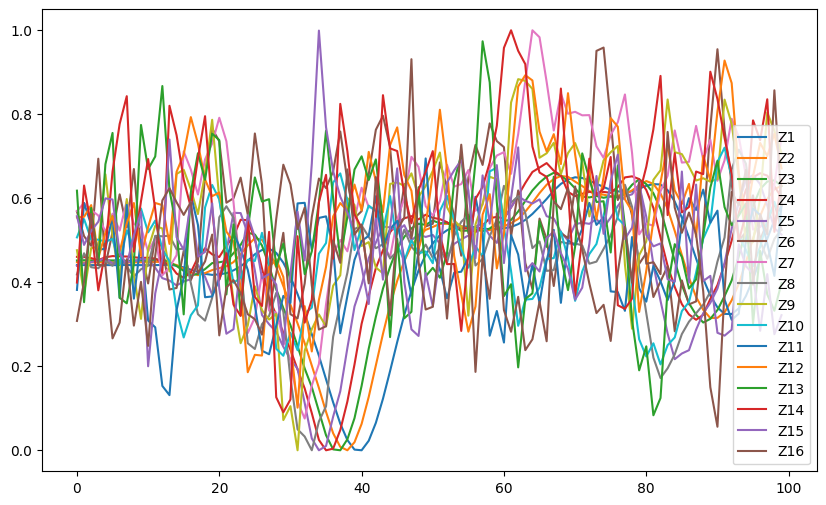

In [158]:
 # Load synthetic data
model = StructuralCausalModel()
num_nodes = 16
nonlinearity = 0.1
interaction_density = 0.25
df, links, causal_graph = model.generate_multi_var_ts(num_nodes, nonlinearity, interaction_density, num_samples=2000)
df.head()

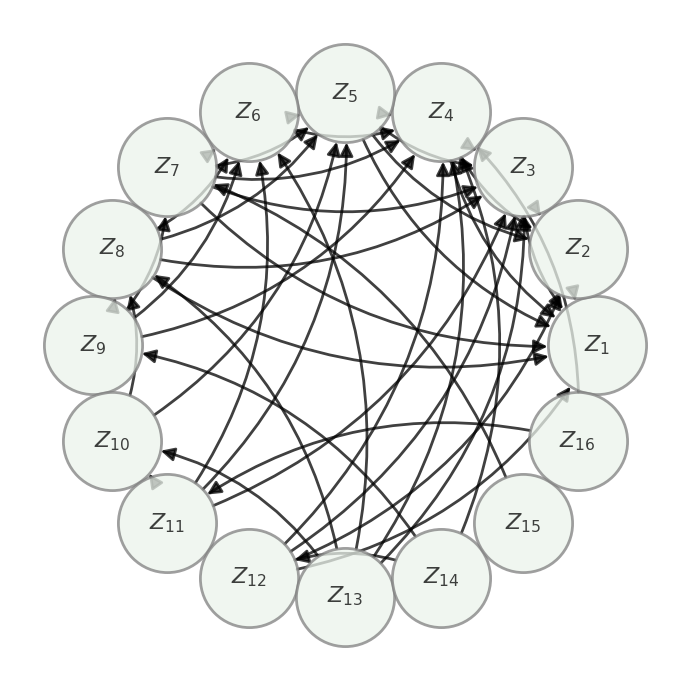

In [159]:
model.draw_causal_graph()

#### Generate Training Dataset

In [160]:
original_data = []
dim, columns = len(df.columns), df.columns
for col in df:
    original_data.append(df[col])

original_data = np.array(original_data)
# training set
train_ds = ListDataset(
    [
        {'start': "01/03/2015 00:00:00",
         'target': original_data[:, 0: training_length].tolist()
         }
    ],
    freq=freq,
    one_dim_target=False
)

#### DeepAR Estimator

In [161]:
# create estimator
estimator = DeepAREstimator(
    prediction_length=prediction_length,
    context_length=prediction_length,
    freq=freq,
    num_layers=num_layers,
    # num_cells=num_cells,
    dropout_rate=dropout_rate,
    trainer=Trainer(
        ctx="cpu",
        epochs=epochs,
        hybridize=False,
        batch_size=32
    ),
    distr_output=MultivariateGaussianOutput(dim=dim)
)

### Load/Train Model

In [162]:
path = pars.get('model_path')
model_path = pathlib.Path(path + model_name)
# model_path = "../models/trained_model_georegime_cli9.sav"
# model_path = "../models/trained_model_syn22Sep.sav"
# model_path = "../models/trained_model_river16Jun.sav"

filename = pathlib.Path(model_path)
print(f'Model: {filename}')
if not filename.exists():
    print('Training DeepAR model....')
    predictor = estimator.train(train_ds)
    # save the model to disk
    pickle.dump(predictor, open(filename, 'wb'))

  0%|          | 0/50 [00:00<?, ?it/s]

Model: /home/ahmad/Projects/gCause/models/trained_model_synthetic4bar.sav16-2
Training DeepAR model....
learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


100%|██████████| 50/50 [00:20<00:00,  2.42it/s, epoch=75/75, avg_epoch_loss=-21.2]


#### Generate Knockoffs

In [163]:
data_actual = np.array(original_data[:, :]).transpose()
n = len(original_data[:, 0])
obj = Knockoffs()
pars.update({'length': n, 'dim': dim, 'col': columns})
knockoffs = obj.Generate_Knockoffs(data_actual, pars)

#### Esimate Causal Links

----------*****-----------------------*****------------
Causal Link: Group: 1 --------------> Group: 2 (Z4)
----------*****-----------------------*****------------


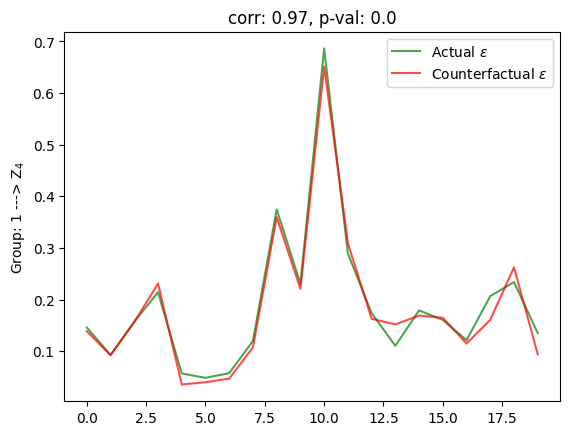

Intervention: In-dist
Test statistic: 0.15, p-value: 0.98
Fail to reject null hypothesis
Intervention: Uniform
Test statistic: 0.25, p-value: 0.57
Fail to reject null hypothesis


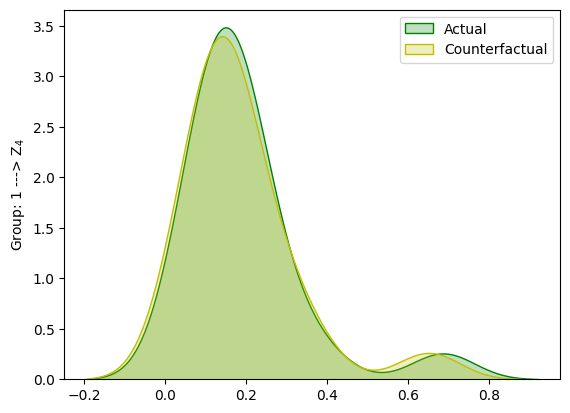

----------*****-----------------------*****------------
Causal Link: Group: 1 --------------> Group: 2 (Z5)
----------*****-----------------------*****------------


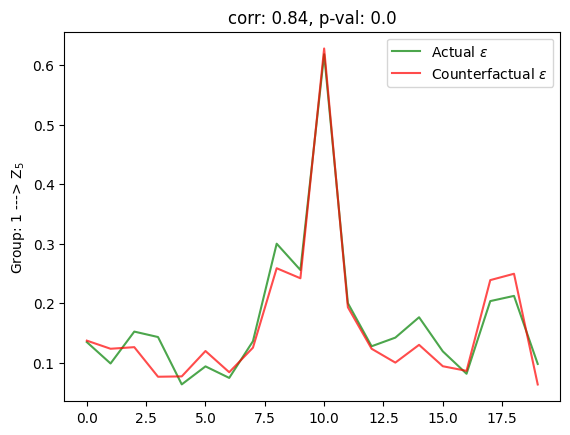

Intervention: In-dist
Test statistic: 0.25, p-value: 0.57
Fail to reject null hypothesis
Intervention: Uniform
Test statistic: 0.5, p-value: 0.01
Null hypothesis is rejected


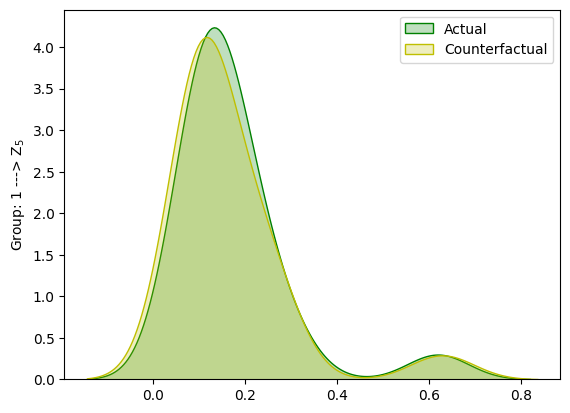

----------*****-----------------------*****------------
Causal Link: Group: 1 --------------> Group: 2 (Z6)
----------*****-----------------------*****------------


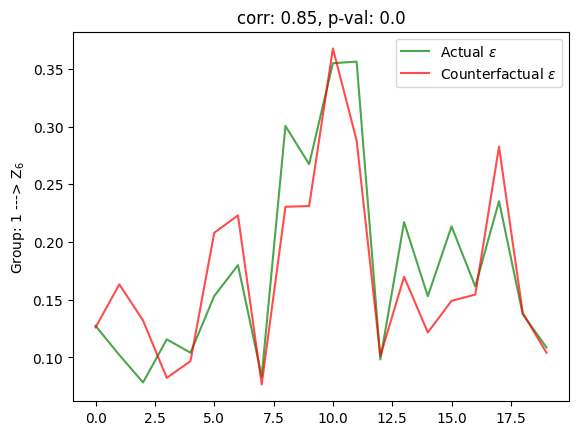

Intervention: In-dist
Test statistic: 0.1, p-value: 1.0
Fail to reject null hypothesis
Intervention: Uniform
Test statistic: 0.65, p-value: 0.0
Null hypothesis is rejected


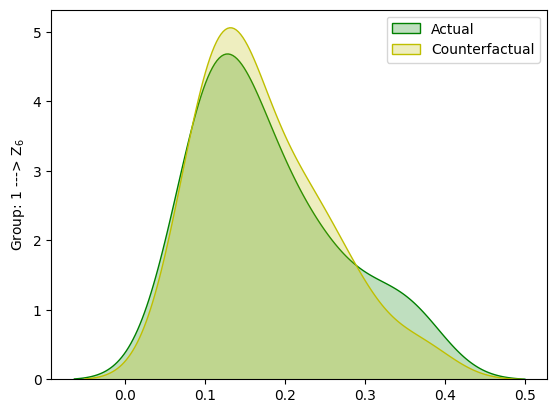

----------*****-----------------------*****------------
Causal Link: Group: 2 --------------> Group: 1 (Z1)
----------*****-----------------------*****------------


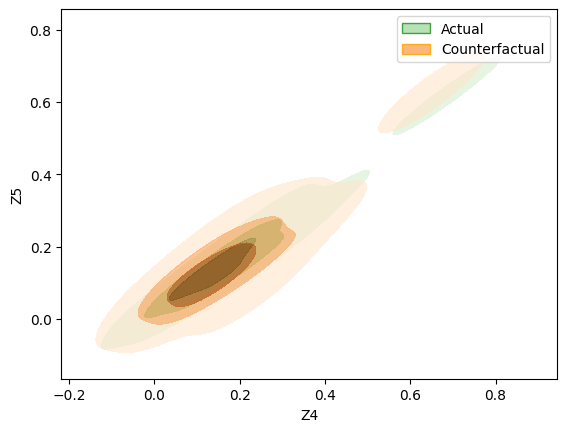

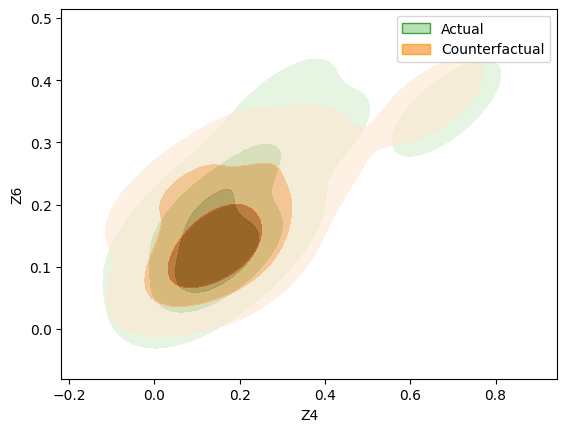

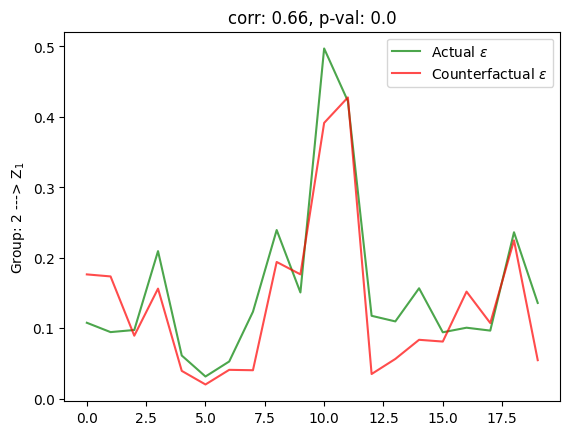

Intervention: In-dist
Test statistic: 0.35, p-value: 0.17
Fail to reject null hypothesis
Intervention: Uniform
Test statistic: 0.75, p-value: 0.0
Null hypothesis is rejected


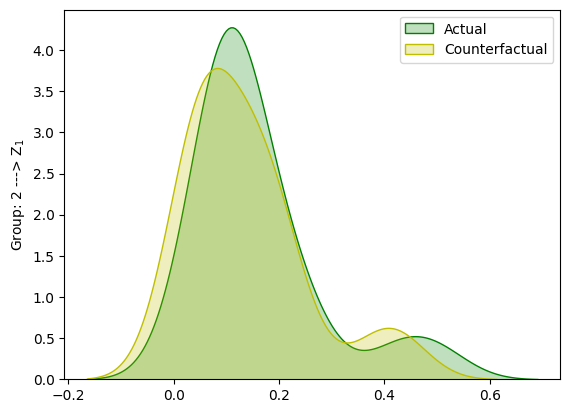

----------*****-----------------------*****------------
Causal Link: Group: 2 --------------> Group: 1 (Z2)
----------*****-----------------------*****------------


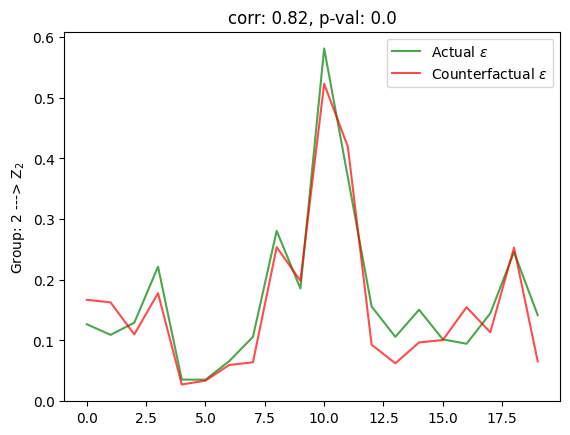

Intervention: In-dist
Test statistic: 0.25, p-value: 0.57
Fail to reject null hypothesis
Intervention: Uniform
Test statistic: 0.55, p-value: 0.0
Null hypothesis is rejected


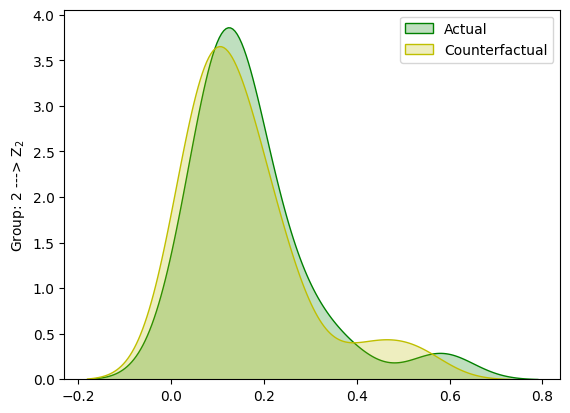

----------*****-----------------------*****------------
Causal Link: Group: 2 --------------> Group: 1 (Z3)
----------*****-----------------------*****------------


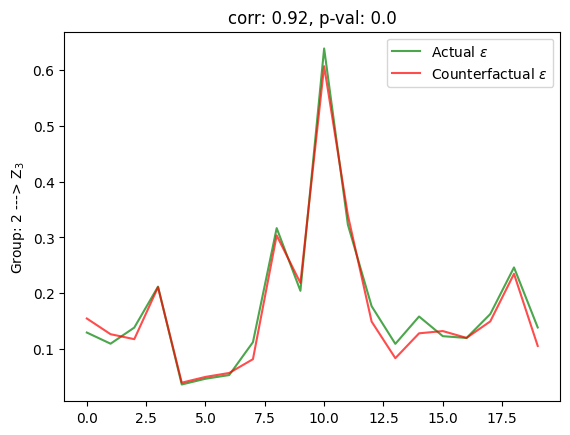

Intervention: In-dist
Test statistic: 0.15, p-value: 0.98
Fail to reject null hypothesis
Intervention: Uniform
Test statistic: 0.45, p-value: 0.03
Null hypothesis is rejected


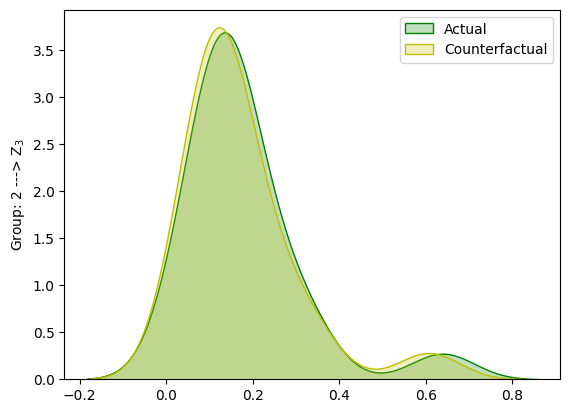

--------------------------------------------------------
Discovered Causal Graphs:  [[0, 0, 0, 0, 0, 0], [0, 1, 1, 1, 1, 1]]
Causal direction: [[0, 0, 0], [0, 0, 0]]
gCDMI: No causal connection found in Group 1 and Group 2
----------*****-----------------------*****------------


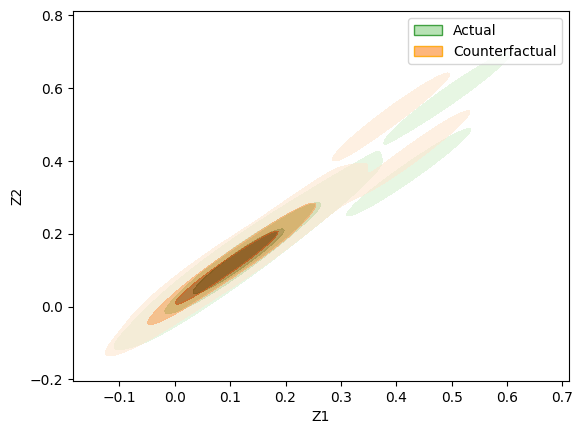

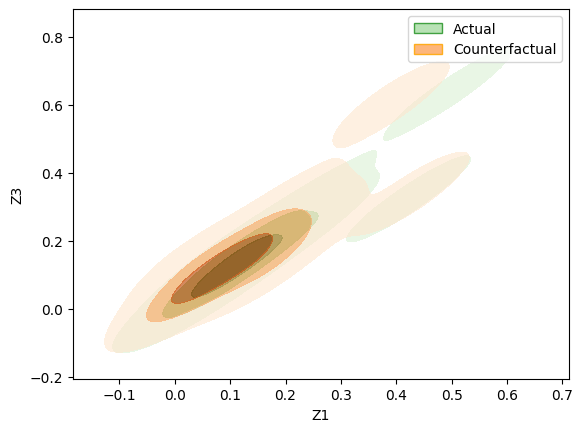

In [164]:
# Function for estimating causal impact among variables
predicted_graph, end_time = groupCause(original_data, knockoffs, model_path, pars)

#### Computation Time

In [165]:
# Calculate difference
elapsed_time = end_time - start_time
# Print elapsed time
print("Computation time: ", round(elapsed_time/60), "mins")

Computation time:  33 mins
